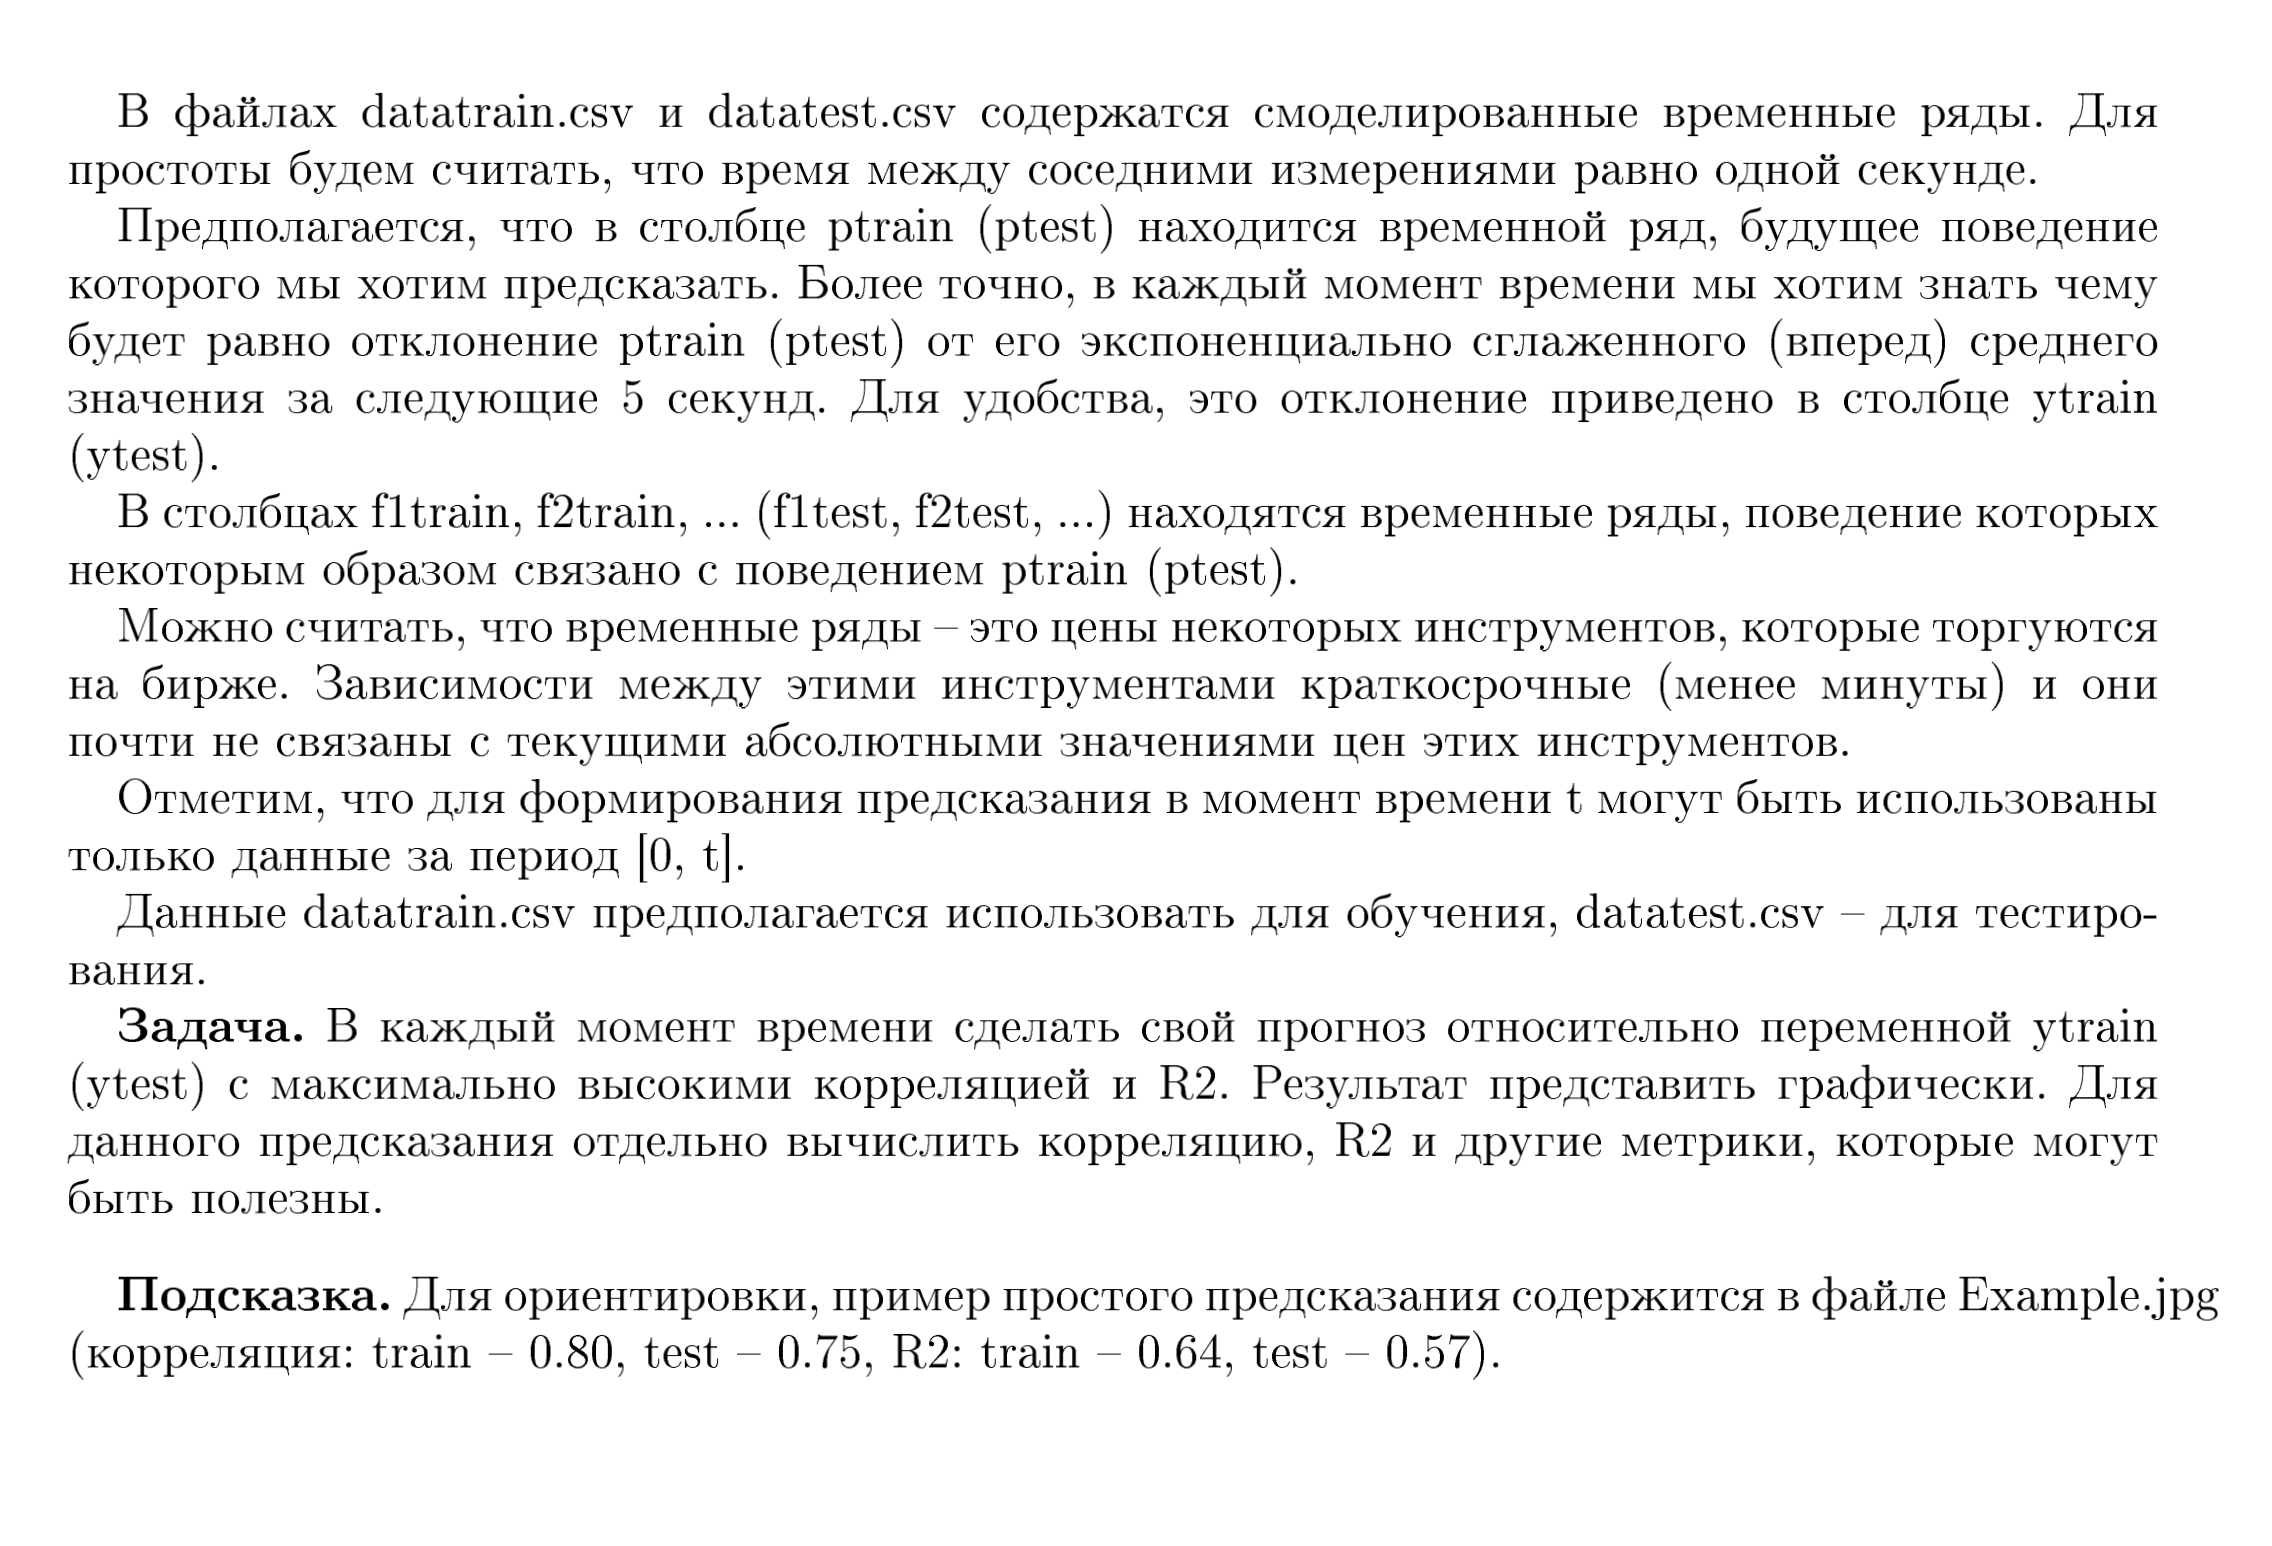

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import plotly.express as px
from matplotlib.pyplot import figure
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


from fastprogress import master_bar, progress_bar
from torch.autograd import Variable


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


torch.cuda.empty_cache()

Thu Mar 18 16:17:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = 'cuda:0'

In [ ]:

train = pd.read_csv(r'datatrain.csv')

train = train.head(round(len(train)/10))
print('length of the dataset: %d'%(len(train)))
print('number of dims: %d' % (len(train.columns)))
train

length of the dataset: 10000
number of dims: 7


ytrain       ptrain      f1train  ...      f3train      f4train      f5train
0     0.673637  1074.969347  1140.697803  ...  1073.522570  2082.532820  1291.340172
1     0.058719  1075.594908  1140.743576  ...  1073.841938  2082.842577  1291.484252
2     0.381526  1075.341261  1141.177709  ...  1073.930892  2083.098220  1291.687519
3     0.528869  1075.289785  1141.062180  ...  1074.061455  2083.308693  1291.672426
4     1.024721  1074.979684  1141.300213  ...  1074.477235  2082.966599  1292.210891
...        ...          ...          ...  ...          ...          ...          ...
9995 -1.408036  1376.881809  1246.039862  ...  1081.294332  2380.162890  1458.535425
9996  0.756886  1374.854088  1245.342496  ...  1082.414338  2381.812426  1459.123532
9997 -7.151867  1381.466427  1245.403541  ...  1079.362086  2381.801365  1459.430079
9998  0.914203  1373.566074  1245.937701  ...  1076.495213  2380.114522  1461.207356
9999  6.299338  1369.322815  1246.563296  ...  1079.506025  2379.166549  1463.070789

[10000 rows x 7 columns]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train['ytrain'] \
                                             .values.astype(float) \
                                             .reshape(-1, 1))


print(train_data_normalized)

[[-0.04595242]
 [-0.07906233]
 [-0.06168099]
 ...
 [-0.46731278]
 [-0.03299922]
 [ 0.25696071]]


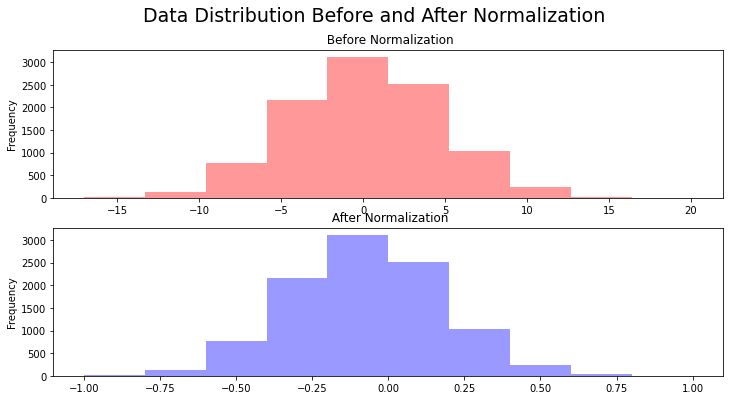

In [ ]:


fig, axs = plt.subplots(2)
 
fig.suptitle('Data Distribution Before and After Normalization ',fontsize = 19)
pd.DataFrame(train['ytrain']).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], 
                        legend = False,
                        title = ' Before Normalization',
                        color ='red') 
pd.DataFrame(train_data_normalized).plot(kind='hist', 
                                         ax = axs[1] ,
                                         figsize=[12,6], 
                                         alpha=.4 , 
                                         legend = False,
                                         title = ' After Normalization'\
                                         ,color = 'blue')

In [ ]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

In [ ]:
seq_length = 60
x, y = sliding_windows(train_data_normalized, 
                       seq_length)


print(x.shape)
print(y.shape)

(9939, 60, 1)
(9939, 1)


In [ ]:
# adding training and validating data

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([6659, 60, 1])
train label shape is: torch.Size([6659, 1])
test shape is: torch.Size([3280, 60, 1])
test label shape is: torch.Size([3280, 1])


In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out = self.dropout(out)
       
        return out

In [ ]:
# create a nn class (just-for-fun choice :-) 
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [ ]:
# Parameters  
num_epochs = 500
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 1
num_classes = 1

# Init the Model
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

# Set Criterion Optimzer and scheduler
criterion = torch.nn.MSELoss().to(device)   
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    
    optimizer.step()
    
    #Evaluate on test     
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1



Epoch: 0, loss: 0.06575 valid loss:  0.06006 
Epoch: 50, loss: 0.05525 valid loss:  0.05320 
Epoch: 100, loss: 0.05527 valid loss:  0.05306 
Epoch: 150, loss: 0.05565 valid loss:  0.05301 
Epoch: 200, loss: 0.05551 valid loss:  0.05299 
Epoch: 250, loss: 0.05590 valid loss:  0.05297 
Epoch: 300, loss: 0.05588 valid loss:  0.05283 
Epoch: 350, loss: 0.05505 valid loss:  0.05273 
Epoch: 400, loss: 0.05532 valid loss:  0.05266 
Epoch: 450, loss: 0.05538 valid loss:  0.05271 


In [ ]:
test = pd.read_csv(r'datatest.csv')
test = test.head(round(len(test)/10))
test_data_normalized = scaler.fit_transform(test['ytest'] \
                                             .values.astype(float) \
                                             .reshape(-1, 1))

test__x, test__y = sliding_windows(test_data_normalized, 
                                   seq_length)

test_dataX = Variable(torch.Tensor(np.array(test__x)))
test_dataY = Variable(torch.Tensor(np.array(test__y)))

testX = Variable(torch.Tensor(np.array(test__x)))
testY = Variable(torch.Tensor(np.array(test__y)))


test_size = len(test__y)


print("test shape is:",testX.size())
print("test label shape is:",testY.size())



test shape is: torch.Size([9939, 60, 1])
test label shape is: torch.Size([9939, 1])


In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Thu Mar 18 15:40:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    33W / 250W |  14347MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

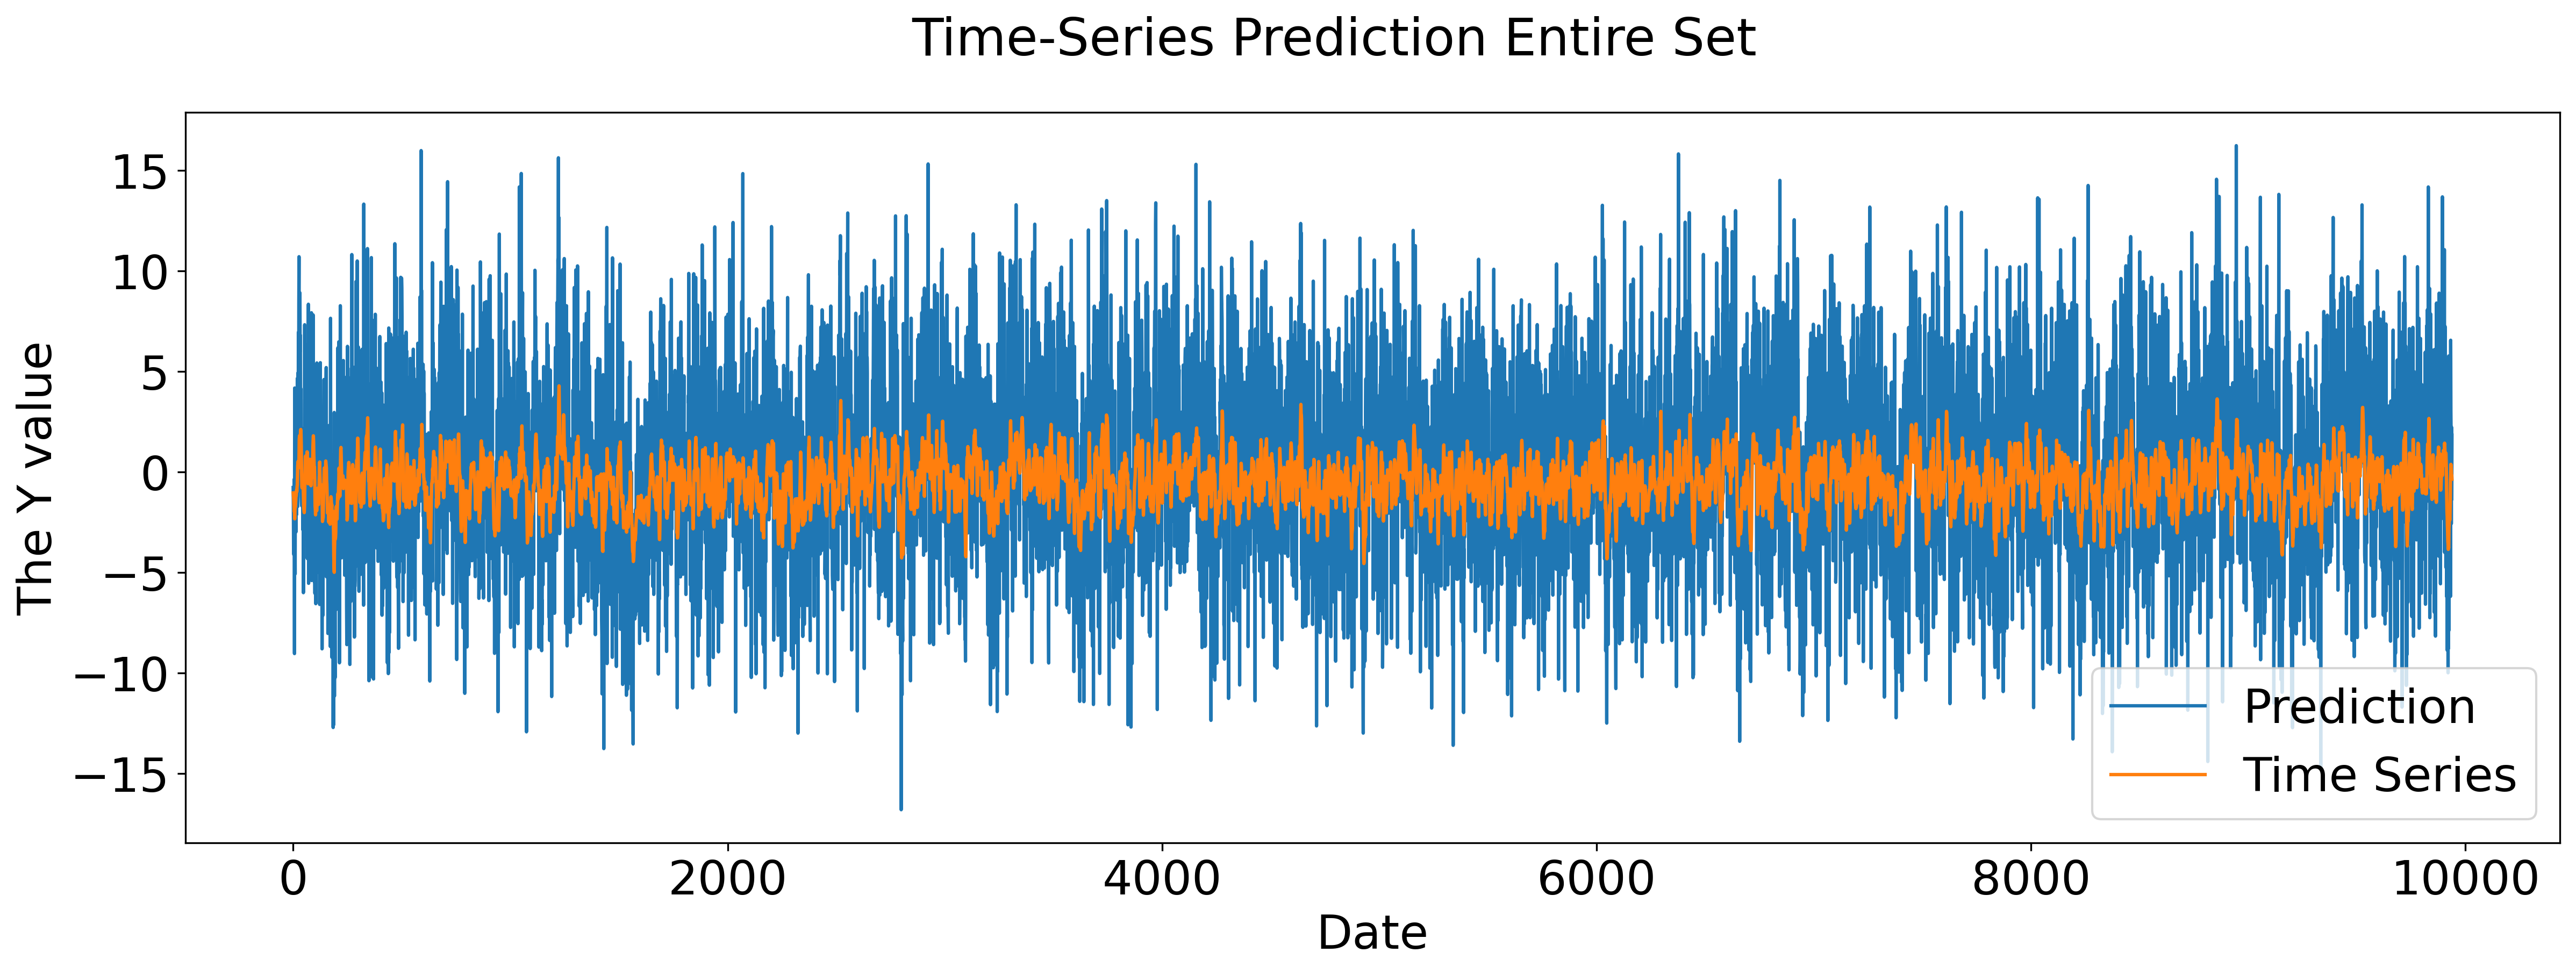

In [ ]:
# Prediction

lstm.eval()
train_predict = lstm(test_dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = test_dataY.data.numpy()

## Inverse Normalize 
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_labels = pd.DataFrame(dataY_plot)

# Plot 
figure(num=None, figsize=(19, 6), dpi=300, facecolor='w', edgecolor='k')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'The Y value',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

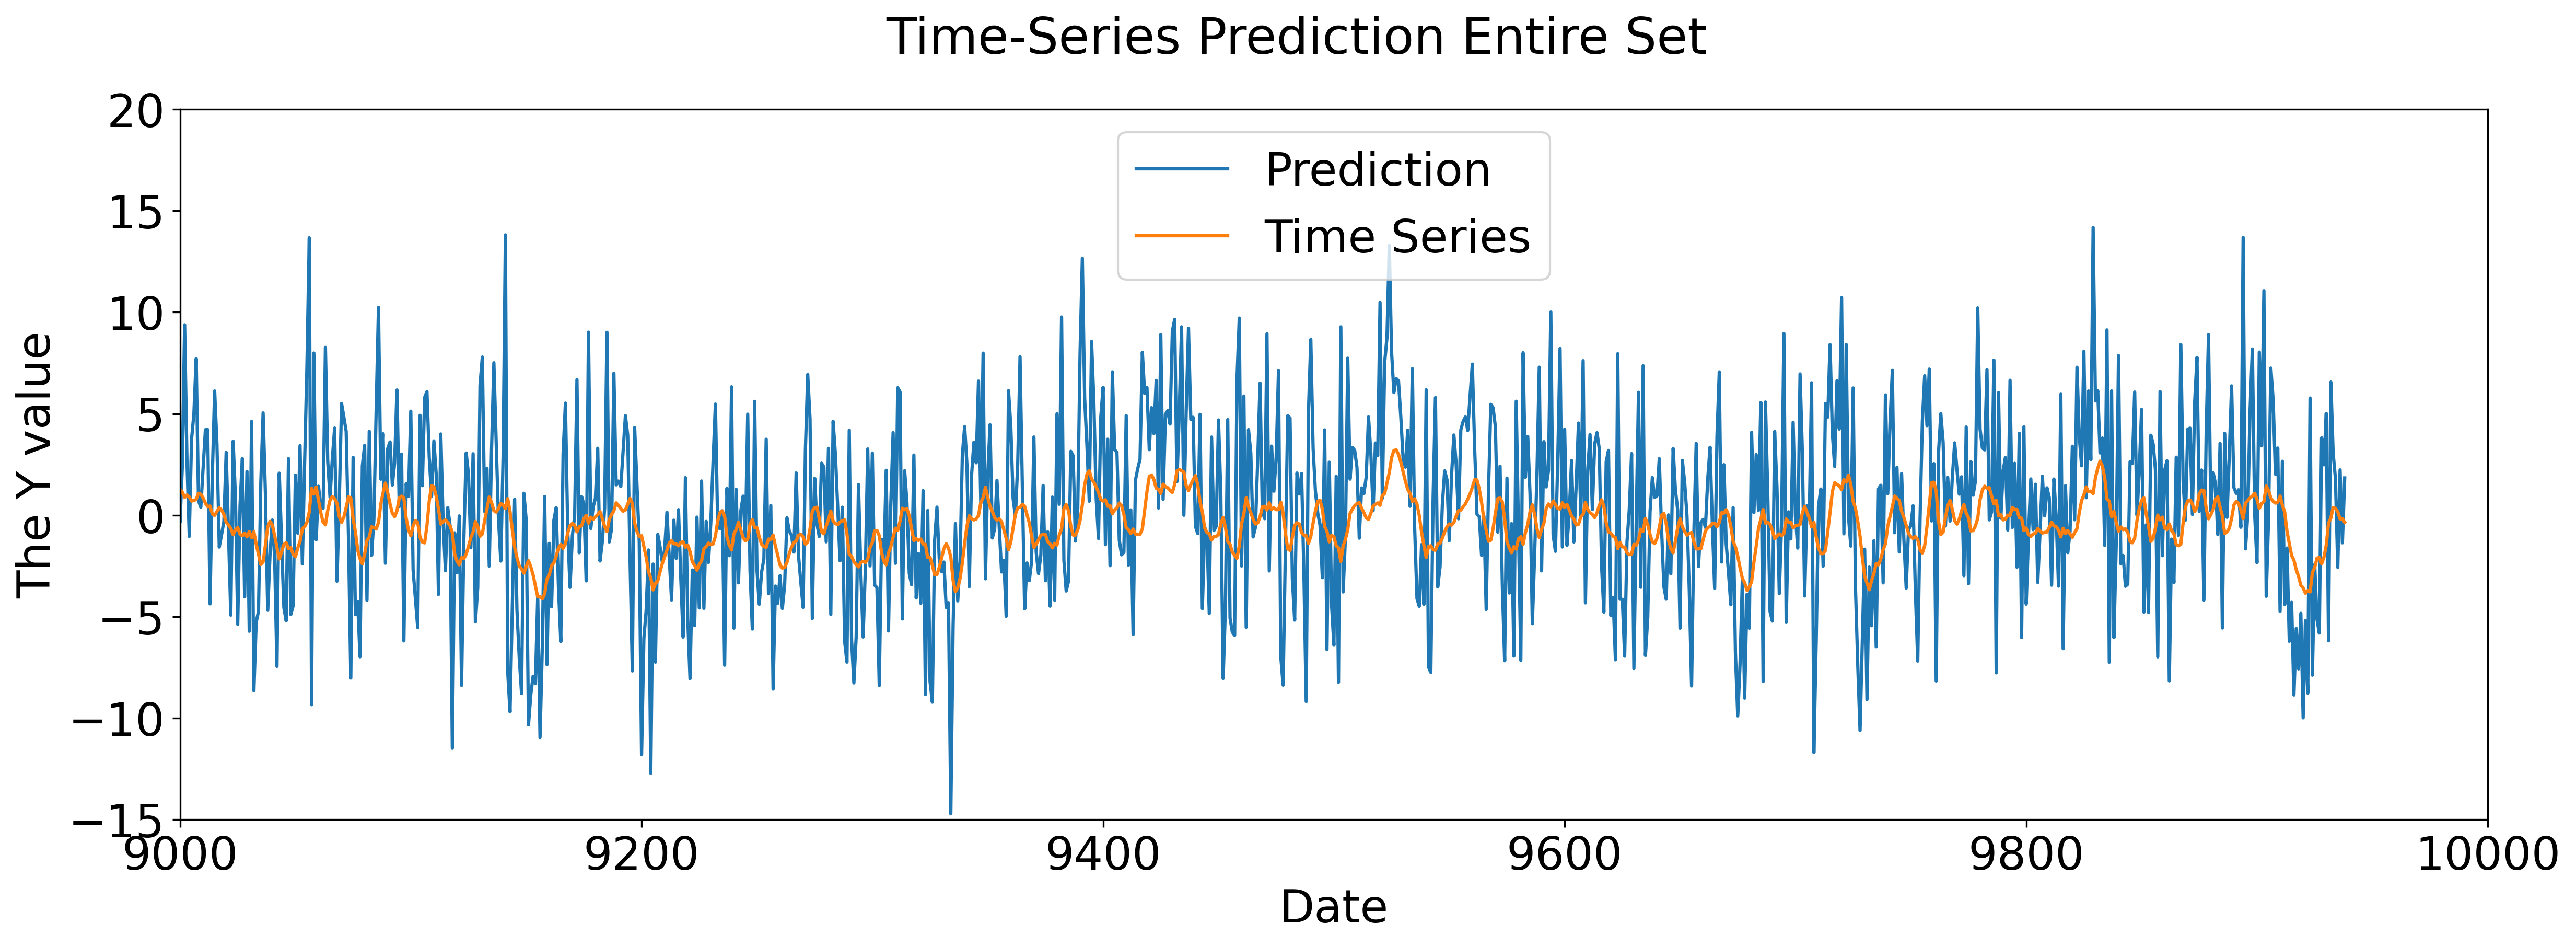

In [ ]:
# Plot of last 10000 iterations
figure(num=None, figsize=(19, 6), dpi=300, facecolor='w', edgecolor='k')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'The Y value',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.axis([9000, 10000, -15, 20])
plt.show()

In [ ]:
print(r2_score(df_labels[0], df_predict[0]))


0.08188202151480428


In [ ]:
class LSTM2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM2, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        
        self.LSTM2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
       
        
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        _, (hn, cn) = self.LSTM2(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out
    
   
        

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [ ]:
num_epochs = 700
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 2

num_classes = 1

lstm = LSTM2(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)


lstm.apply(init_weights)

criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    scheduler.step(loss)
    optimizer.step()
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

Epoch: 0, loss: 0.06222 valid loss:  0.31796 
Epoch: 50, loss: 0.05321 valid loss:  0.05256 
Epoch: 100, loss: 0.05306 valid loss:  0.05235 
Epoch: 150, loss: 0.05310 valid loss:  0.05231 
Epoch: 200, loss: 0.05309 valid loss:  0.05227 
Epoch: 250, loss: 0.05307 valid loss:  0.05225 
Epoch: 300, loss: 0.05304 valid loss:  0.05222 


Epoch: 350, loss: 0.05305 valid loss:  0.05220 
Epoch: 400, loss: 0.05303 valid loss:  0.05218 
Epoch: 450, loss: 0.05299 valid loss:  0.05214 
Epoch: 500, loss: 0.05292 valid loss:  0.05210 
Epoch: 550, loss: 0.05287 valid loss:  0.05206 
Epoch: 600, loss: 0.05292 valid loss:  0.05206 
Epoch: 650, loss: 0.05288 valid loss:  0.05205 


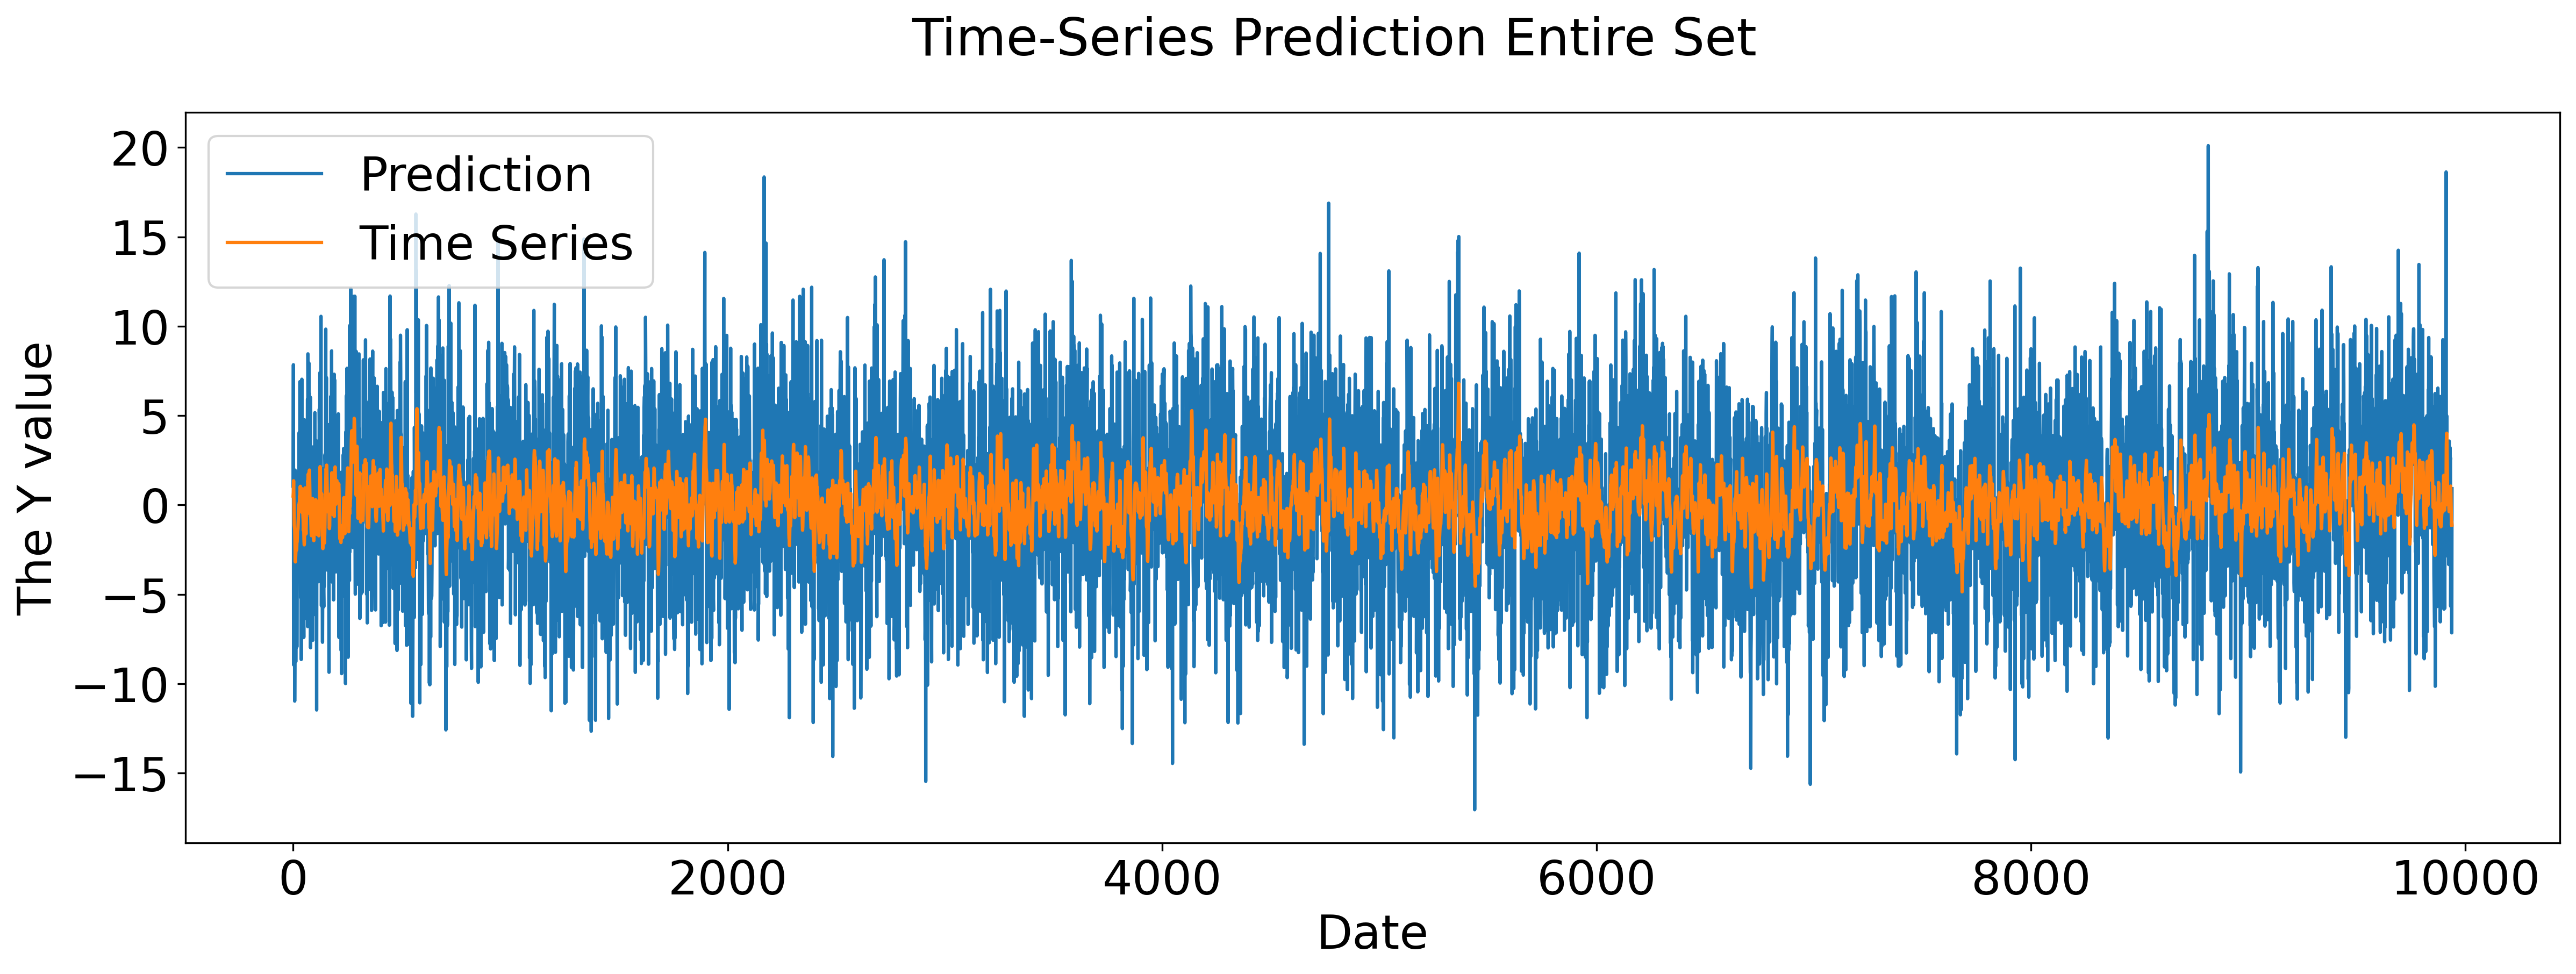

In [ ]:
# Prediction

lstm.eval()
train_predict = lstm(test_dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = test_dataY.data.numpy()

## Inverse Normalize 
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_labels = pd.DataFrame(dataY_plot)

# Plot 
figure(num=None, figsize=(19, 6), dpi=300, facecolor='w', edgecolor='k')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'The Y value',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

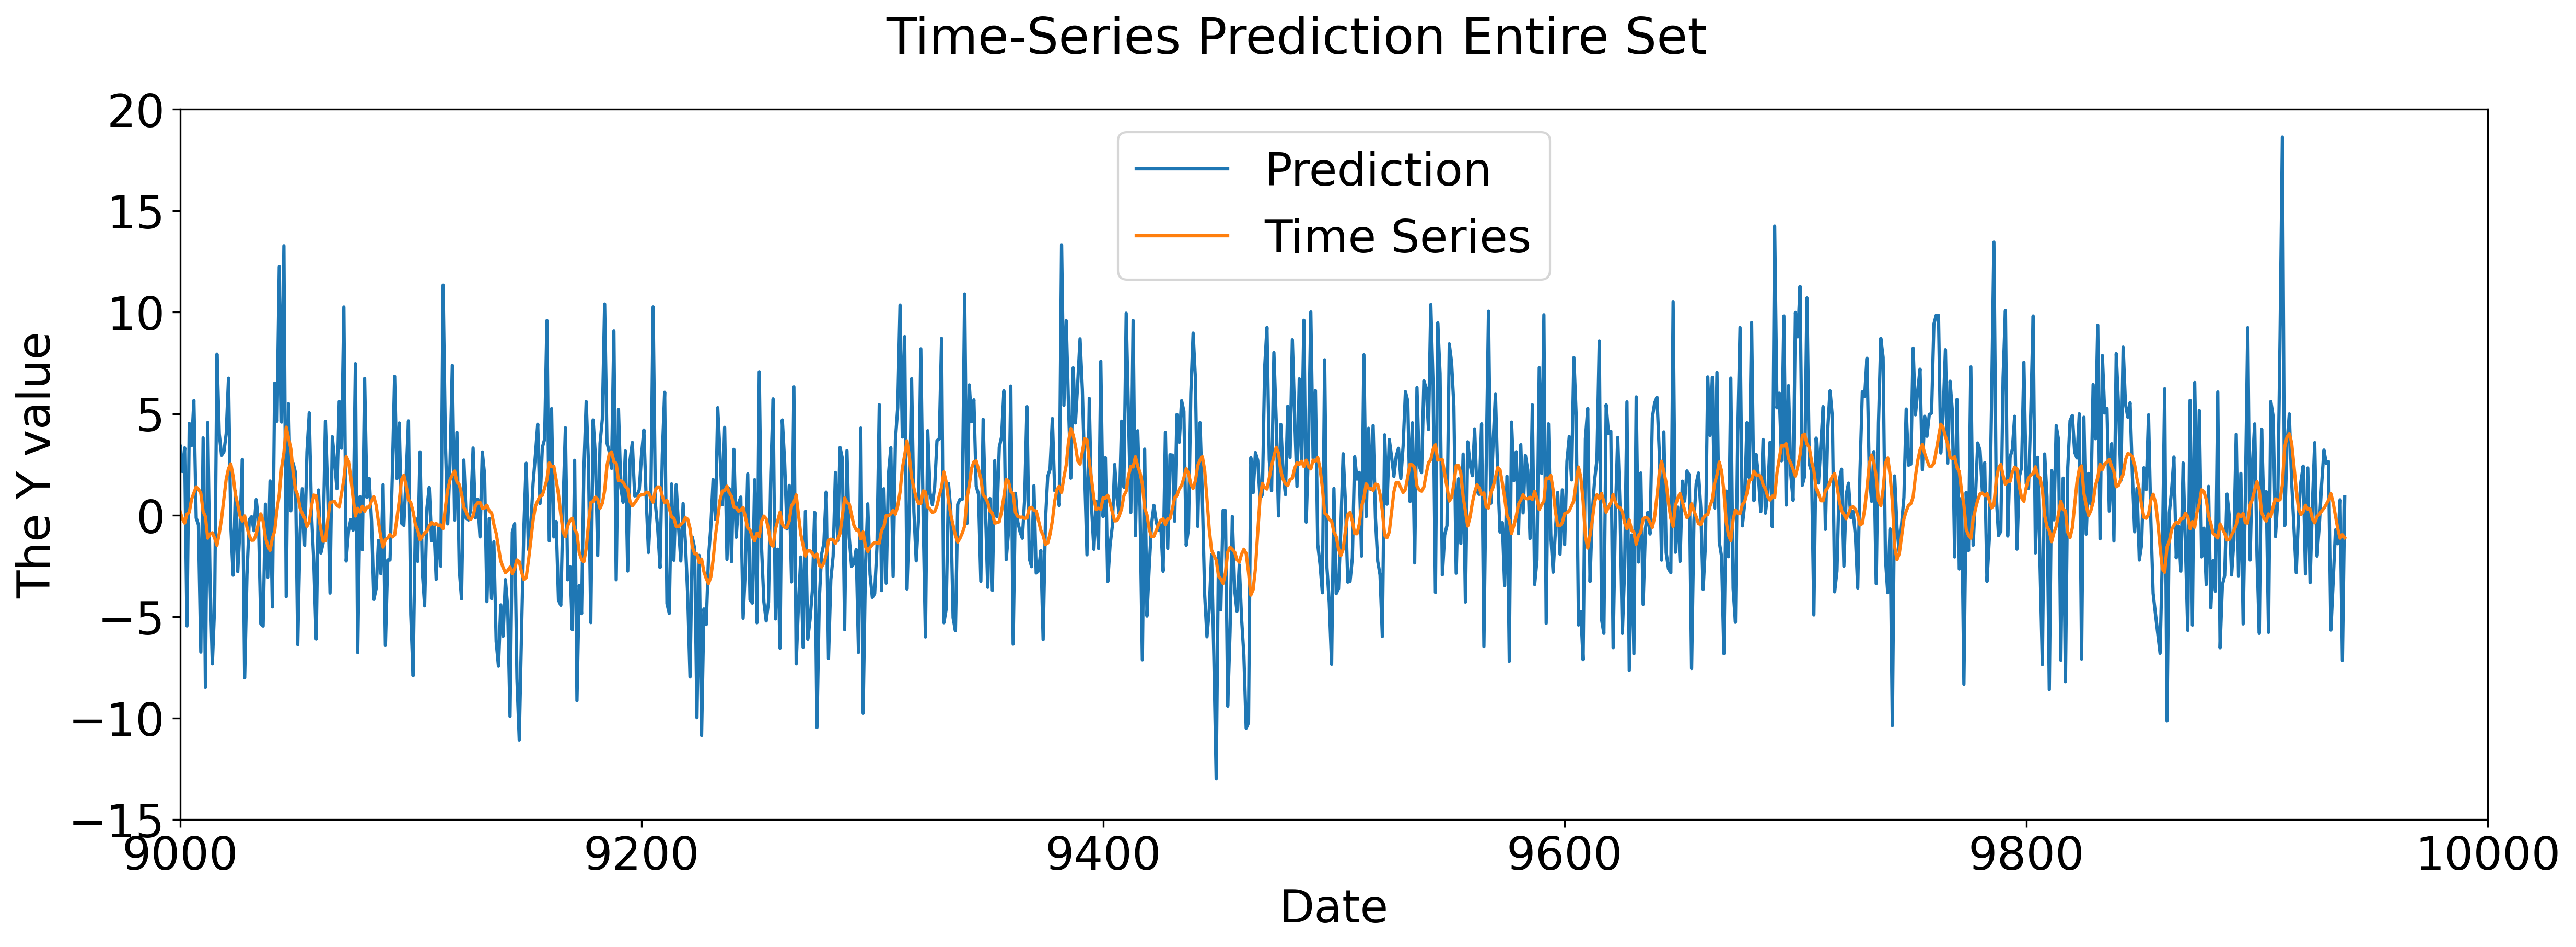

In [ ]:

# Plot 
figure(num=None, figsize=(19, 6), dpi=300, facecolor='w', edgecolor='k')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'The Y value',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.axis([9000, 10000, -15, 20])
plt.show()

In [ ]:
print(r2_score(df_labels[0], df_predict[0]))


0.11708161115298743